### Multi class insect classifier

Using the knowlege obtained from the last few fastai lessons, I will recreate the insect classifier. This time it will be treated as a multicategory classification problem to allow our inferer to deal with a picture of several insects and also allow it to indicate that no insects were detected in the user picture. 

Also some additional data will be gathered to further improve the classifier and a new category for moths and spiders will be added. 

Lets get to it!

First as always imports:

In [95]:
from fastai.vision.all import *
from fastbook import search_images_bing
from fastai.vision.widgets import *
import os

#### Gather additional data

In [2]:
from private import key

In [30]:
insect_types = ["spider", "silverfish", "cockroach", "fruit fly", "bed bug", "mosquito", "moth"]
path = Path("insects")

Here we add "common house" to the search term to hopefully remove as many pictures as possible relating to exterminating the given insect type

In [31]:
for insect in insect_types:
    insect_dir = path/insect
    if not insect_dir.exists(): # only gather images if dir does not exist
        insect_dir.mkdir() # create a dir per insect if does not exist
        # gather image urls
        img_urls = search_images_bing(key, f"common house {insect}", min_sz=256, max_images=150).attrgot("contentUrl")
        download_images(insect_dir, urls=img_urls, preserve_filename=True)
    

In [78]:
images = get_image_files(path) # get all images
corrupt_images = verify_images(images) # idenitfy corrupt images
corrupt_images.map(Path.unlink) # delete corrupt images

(#7) [None,None,None,None,None,None,None]

We now have 1.4k of images to attempt to train our classifier on. So lets get to loading all of the data into dataloaders :)

In [79]:
img_count = 0
for subpath in path.ls():
    img_count += len(subpath.ls())
img_count

1398

#### Load data into dataloaders

In [65]:
def return_list(x): return [x]

In [106]:
insects_db = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    splitter = RandomSplitter(seed=42),
    get_items = get_image_files,
    get_y = Pipeline([RegexLabeller(r'insects/([^/]+)/'), return_list]),
    item_tfms = Resize(256),
    batch_tfms = aug_transforms(mult=1.2, size=128, min_scale=0.75)
)
insects_dls = insects_db.dataloaders(path, bs=32, shuffle=True)    

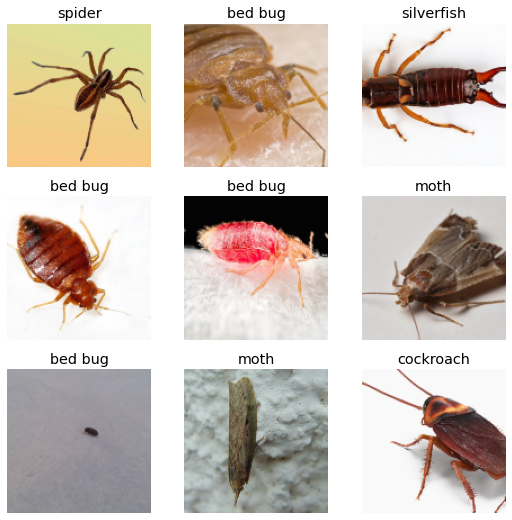

In [107]:
insects_dls.show_batch()

#### Setup and train model

In [108]:
thresh = 0.6
learner = cnn_learner(insects_dls, resnet50, metrics=partial(accuracy_multi, thresh=thresh)).to_fp16()

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantl

SuggestedLRs(valley=0.0010000000474974513)

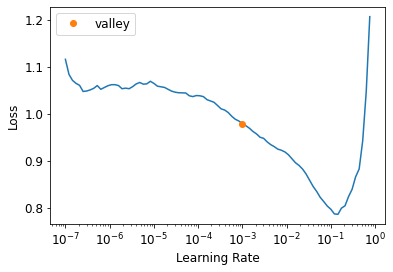

In [90]:
learner.freeze()
learner.lr_find()

Good LR could be 3e-3 so lets start with that to get something trained to subsequently clean some data and then optimize for the best threshold

In [109]:
learner.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.827557,0.589950,0.793766,00:21
1,0.560917,0.234602,0.931948,00:22
2,0.360430,0.135071,0.957922,00:22
3,0.252167,0.120009,0.962597,00:21
4,0.196263,0.115185,0.961559,00:21


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency e

It appears our network is already doing great but lets improve it a bit further by tuning all the weights, just using a much smaller LR for the earlier layers

In [110]:
learner.unfreeze()
#learner.lr_find()

And now we will train the whole network instead of jsut the final layer but we will use 1000x lower learning rate for the first layer

In [111]:
learner.fit_one_cycle(5, slice(2e-7, 2e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.126801,0.114338,0.960000,00:22
1,0.129970,0.120452,0.962597,00:21
2,0.118343,0.111767,0.962597,00:21
3,0.115106,0.110876,0.962597,00:22
4,0.110809,0.108286,0.962078,00:22


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency e

#### Clean data

In [112]:
interp = ClassificationInterpretation.from_learner(learner)

[0] insects/bed bug/Spider.jpg
[1] insects/bed bug/ant-banner-youtube-1100x510.jpg
[2] insects/moth/clothes-moth-1.jpg
[3] insects/fruit fly/common-fruit-fly-purple-orchids-69919528.jpg
[4] insects/moth/hqdefault.jpg
[5] insects/bed bug/00000102.jpg
[6] insects/bed bug/boxelders_jody.jpg
[7] insects/moth/indianmealmoth_larva.jpg
[8] insects/cockroach/00000093.JPG
[9] insects/silverfish/e3174a09cf6890eb70f535f6b17a03b7.jpg
[10] insects/silverfish/00000078.png
[11] insects/bed bug/ac65cf6654e6dbd64d951a03d00b30e0.jpg


,target,predicted,probabilities,loss
0,bed bug,spider,"TensorBase([0.0016, 0.0020, 0.0067, 0.0022, 0.0040, 0.0323, 1.0000])",2.7291598320007324
1,bed bug,cockroach,"TensorBase([0.0112, 0.7677, 0.0550, 0.2388, 0.0126, 0.0044, 0.0368])",0.9045275449752808
2,moth,mosquito,"TensorBase([0.1767, 0.0053, 0.0180, 0.5281, 0.0110, 0.0719, 0.0059])",0.7943519353866577
3,fruit fly,mosquito,"TensorBase([0.0207, 0.0025, 0.1220, 0.9658, 0.0093, 0.0041, 0.0091])",0.789472758769989
4,moth,,"TensorBase([0.0890, 0.0333, 0.0092, 0.0775, 0.0109, 0.1196, 0.3821])",0.7635213732719421
5,bed bug,fruit fly,"TensorBase([0.1313, 0.0075, 0.9394, 0.3561, 0.0025, 0.0317, 0.0129])",0.7612396478652954
6,bed bug,,"TensorBase([0.0251, 0.0300, 0.3862, 0.0651, 0.0206, 0.0400, 0.0511])",0.6262500286102295
7,moth,,"TensorBase([0.2928, 0.0064, 0.2729, 0.0311, 0.0269, 0.0204, 0.0109])",0.6214252710342407
8,cockroach,bed bug;mosquito,"TensorBase([0.5186, 0.0930, 0.1082, 0.5894, 0.0496, 0.0357, 0.0509])",0.6071542501449585
9,silverfish,mosquito,"TensorBase([0.0979, 0.0214, 0.0501, 0.8516, 0.0067, 0.1212, 0.0072])",0.6011927127838135


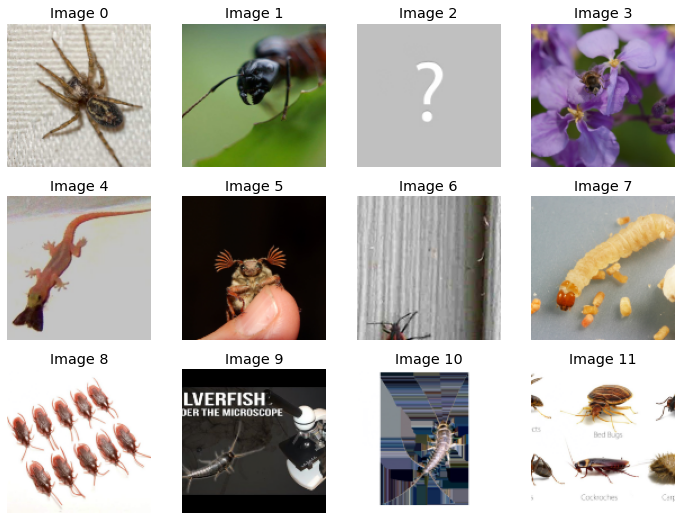

In [114]:
x = 0
for i in interp.top_losses(12).indices:
    print(f"[{x}] {insects_dls.valid_ds.items[i]}")
    x += 1
interp.plot_top_losses(12, nrows=3)

Save the cleaned model to be used for the inferer

In [117]:
learner.export(fname="multimod.pkl")